# Plot

> Functions to plot motif logo, heatmap, scatter plot, and others.

## Setup

In [1]:
#|default_exp plot

In [2]:
#| export
import joblib,logomaker
import pandas as pd, numpy as np, seaborn as sns
from adjustText import adjust_text
from pathlib import Path
from tqdm import tqdm
from fastcore.meta import delegates

from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from numpy import trapz

# Katlas
from katlas.feature import *
from katlas.data import *

# Bokeh
from bokeh.io import output_notebook, show
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, AutocompleteInput, CustomJS
from bokeh.layouts import column
from bokeh.palettes import Category20_20
from itertools import cycle
import math

# Dimension Reduction
from sklearn import set_config
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap.umap_ import UMAP

from sklearn.metrics import pairwise_distances

import matplotlib.ticker as mticker

import matplotlib as mpl

## Utils

In [3]:
#| export
def set_sns(dpi=300):
    "Set seaborn resolution for notebook display"
    sns.set(rc={"figure.dpi":dpi, 'savefig.dpi':dpi}) # savefig.dpi is ignored when saved in svg or pdf
    sns.set_context('notebook')
    sns.set_style("ticks")

In [4]:
#| export
def save_svg(path): 
    plt.rcParams['svg.fonttype'] = 'none'
    return plt.savefig(path, format='svg', bbox_inches='tight',transparent=True)

In [5]:
#| export
def save_pdf(path): 
    mpl.rcParams['pdf.fonttype'] = 42  # Use TrueType fonts for Illustrator compatibility
    mpl.rcParams['ps.fonttype'] = 42   # Also good for EPS, if needed
    plt.savefig(path, format='pdf', bbox_inches='tight',transparent=True)

In [6]:
#| export
def save_show(path=None, # image path, e.g., img.svg, if not None, will save, else plt.show()
              show_only=False,
             ):
    "Show plot or save path"
    if show_only: plt.show()
    elif path is not None: plt.savefig(path, bbox_inches='tight', pad_inches=0.05)
    else: plt.show()
    plt.close()

## Color/palette

In [7]:
#| export
def get_color_dict(categories, # list of names to assign color
                   palette: str='tab20', # choose from sns.color_palette
                   ):
    "Assign colors to a list of names (allow duplicates), returns a dictionary of unique name with corresponding color"
    p=sns.color_palette(palette)
    color_cycle = cycle(p)
    color_map = {category: next(color_cycle) for category in categories}
    return color_map

In [8]:
#| export
sty_color=get_color_dict(['S','T','Y'])

In [9]:
info = Data.get_kinase_info()

In [10]:
info.modi_group.value_counts().index

Index(['TK', 'CAMK', 'Other', 'CMGC', 'AGC', 'STE', 'TKL', 'Atypical', 'CK1',
       'NEK', 'RGC'],
      dtype='object', name='modi_group')

In [11]:
#| export
group_color=get_color_dict(
            ['CMGC','AGC', # blue
             'TK','TKL', # orange
             'CAMK','STE', # green
             'CK1', 'NEK', # red
             'Atypical','Other', # purple
             'RGC'
            ]
)

In [12]:
info.pspa_category_big.str.split('_').str[0].value_counts()[:20].index

Index(['Basophilic', 'Pro-directed', 'Acidophilic', 'Map3k', 'Map4k',
       'Alpha/mlk', 'Fgf and vegf receptors', 'Assorted', 'Ripk/wnk', 'Pkc',
       'Ephrin receptors', 'Eif2ak/tlk', 'Nek/ask', 'Pdgf receptors', 'Src',
       'Jak', 'Tam receptors', 'Cmgc', 'Tec', 'Ulk/ttbk'],
      dtype='object', name='pspa_category_big')

In [13]:
#| export
pspa_category_color = get_color_dict(['Basophilic', 'Pro-directed', 'Acidophilic', 'Map3k', 'Map4k',
       'Alpha/mlk', 'Fgf and vegf receptors', 'Assorted', 'Ripk/wnk', 'Pkc',
       'Ephrin receptors', 'Eif2ak/tlk', 'Nek/ask', 'Pdgf receptors', 'Src',
       'Jak', 'Ulk/ttbk', 'Cmgc', 'Tec', 'Tam receptors'])

Sometimes plot functions do not take dict of colors but list of colors:

In [14]:
#| export
def get_plt_color(palette, # dict, list, or set name (tab10)
                  columns, # columns in the df for plot
                 ):
    "Given a dict, list or set name, return the list of names; if dict, need to provide column names of the df."
    if isinstance(palette, dict):
        # Match colors to column order in pct_df
        colors = [palette.get(col, '#cccccc') for col in columns]  # fallback color if missing
    elif isinstance(palette, str):
        colors = sns.color_palette(palette, n_colors=len(columns))
    elif isinstance(palette, list):
        colors = palette
    return colors

In [15]:
get_plt_color('Set2',['a','b'])

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961)]

In [16]:
#| export
def get_hue_big(df,
                hue_col, # column of hue
                cnt_thr=10, # higher or equal to this threshold will be considered
               ):
    "Get part of hue according to its value counts; applied when the groups are too many."
    cnt = df[hue_col].value_counts()
    names = cnt[cnt>=cnt_thr].index
    return df[hue_col][df[hue_col].isin(names)]

When the categories are too many to show on the plot, we can filter and only show those big categories:

In [17]:
hue_big=get_hue_big(info,'pspa_category_big',10)
hue_big

5      Acidophilic
6      Acidophilic
11      Basophilic
12      Basophilic
13      Basophilic
          ...     
516    Acidophilic
517    Acidophilic
519          Map4k
520          Map3k
521          Map3k
Name: pspa_category_big, Length: 294, dtype: object

In [18]:
# plot_2d(embed,hue=hue_pspa,hue_title='PSPA category',palette='tab20')

## Dimensionality reduction

In [19]:
#| export
def reduce_feature(df: pd.DataFrame, 
                   method: str='pca', # dimensionality reduction method, accept both capital and lower case
                   complexity: int=20, # None for PCA; perfplexity for TSNE, recommend: 30; n_neigbors for UMAP, recommend: 15
                   n: int=2, # n_components
                   load: str=None, # load a previous model, e.g. model.pkl
                   save: str=None, # pkl file to be saved, e.g. pca_model.pkl
                   seed: int=123, # seed for random_state
                   **kwargs, # arguments from PCA, TSNE, or UMAP depends on which method to use
                  ):
    
    "Reduce the dimensionality given a dataframe of values"
    
    method = method.lower()
    assert method in ['pca','tsne','umap'], "Please choose a method among PCA, TSNE, and UMAP"
    
    if load is not None:
        reducer = joblib.load(load)
    else:
        if method == 'pca':
            reducer = PCA(n_components=n, random_state=seed,**kwargs)
        elif method == 'tsne':
            reducer = TSNE(n_components=n,
                           random_state=seed, 
                           perplexity = complexity, # default from official is 30 
                          **kwargs)
        elif method == 'umap':
            reducer = UMAP(n_components=n, 
                           random_state=seed, 
                           n_neighbors=complexity, # default from official is 15, try 15-200
                          **kwargs)
        else:
            raise ValueError('Invalid method specified')

    proj = reducer.fit_transform(df)
    embedding_df = pd.DataFrame(proj).set_index(df.index)
    embedding_df.columns = [f"{method.upper()}{i}" for i in range(1, n + 1)]

    if save is not None:
        path = Path(save)
        path.parent.mkdir(exist_ok=True)
        
        joblib.dump(reducer, save)

    return embedding_df

A very common way to reduce feature number is to use dimensionality reduction method. `reduce_feature` is a dimensionality reduction function that can apply three dimensionality reduction methods: PCA, UMAP, TSNE. The later two is non-linear transformation, and PCA is linear transformation. Therefore, for plotting purpose, it is good to use UMAP/TSNE, by setting n (n_components) to 2 for 2d plot; for featuring purpose, it is good to use PCA, and set n to values to a rational values, like 64, 128 etc. 

In [20]:
# Load data
df=Data.get_aa_morgan()

# Use PCA to reduce dimension; reduce the number of features to 20
feat = reduce_feature(df,'pca',n=2)
feat.head()

,PCA1,PCA2
aa,,
A,-0.954819,-0.953761
C,-0.041108,0.205091
D,-0.087707,0.245634
E,-0.271097,1.023801
F,2.253264,-0.251185


## 2D scatter plot

In [21]:
# #| export
# @delegates(sns.scatterplot)
# def plot_2d(X: pd.DataFrame, # a dataframe that has first column to be x, and second column to be y
#             hue_title=None, # legend box title
#             hue_order=None,
#             figsize=(7,7),
#             **kwargs, # arguments for sns.scatterplot
#             ):
#     """
#     Make 2D plot from a dataframe that has first column to be x, and second column to be y.
#     Legend box on the right.
#     """
#     fig, ax = plt.subplots(figsize=figsize)
#     hue_data = kwargs.get('hue')
#     if hue_data is not None and hue_order is not None: 
#         # Filter hue_order to only include present labels
#         hue_order = [k for k in hue_order if k in pd.Series(hue_data).unique()]
#     sns.scatterplot(data=X, 
#                     x=X.columns[0], y=X.columns[1], 
#                     hue_order=hue_order,
#                     alpha=0.7, ax=ax, **kwargs)
#     # have legend box on the right
#     if hue_data is not None: ax.legend(title=hue_title, loc='center left', bbox_to_anchor=(1.02, 0.5))

In [22]:
#| export
def plot_2d(
    embedding_df: pd.DataFrame,  # a dataframe of values that is waited for dimensionality reduction
    hue: str = None,  # colname of color
    complexity: int = 30,  # this argument does not affect pca but others; recommend 30 for tsne, 15 for umap
    palette: str = 'tab20',  # color scheme, could be tab10 if less categories
    legend: bool = False,  # whether or not add the legend on the side
    name_list=None,  # a list of names to annotate each dot in the plot
    seed: int = 123,  # seed for dimensionality reduction
    s: int = 20,  # size of the dot
    legend_title: str = None,  # new argument to override legend title
    **kwargs  # arguments for dimensional reduction method to be used
):
    """
    Given a dataframe of values, plot it in 2D. 
    The method could be 'pca', 'tsne', or 'umap'.
    """
    x_col, y_col = embedding_df.columns 
    
    g = sns.relplot(
        data=embedding_df, x=x_col, y=y_col, hue=hue, palette=palette, s=s, alpha=0.8, legend=legend
    )
    plt.xticks([])
    plt.yticks([])

    # Override legend title if specified
    if legend and legend_title is not None:
        if g._legend is not None:
            g._legend.set_title(legend_title)

    # Add text annotations
    if name_list is not None:
        ax = g.ax
        texts = [
            ax.text(
                embedding_df[x_col].iloc[i], embedding_df[y_col].iloc[i], str(name_list[i]), fontsize=8
            ) for i in range(len(embedding_df))
        ]
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))

/tmp/ipykernel_262181/600276515.py:20: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.relplot(


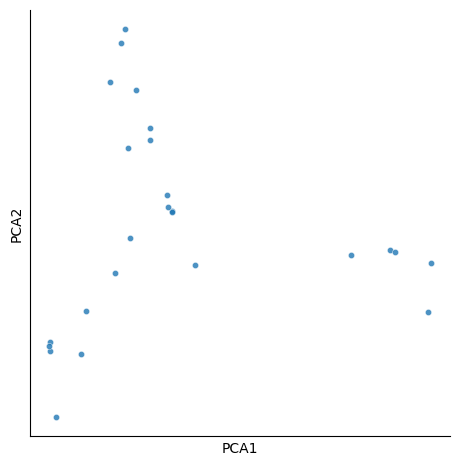

In [23]:
plot_2d(feat)

## Dimensionality reduction + 2d plot

In [24]:
#| export
def plot_cluster(
    df: pd.DataFrame,  # a dataframe of values that is waited for dimensionality reduction
    method: str = 'pca',  # dimensionality reduction method, choose from pca, umap, and tsne
    hue: str = None,  # colname of color
    complexity: int = 30,  # this argument does not affect pca but others; recommend 30 for tsne, 15 for umap
    palette: str = 'tab20',  # color scheme, could be tab10 if less categories
    legend: bool = False,  # whether or not add the legend on the side
    name_list=None,  # a list of names to annotate each dot in the plot
    seed: int = 123,  # seed for dimensionality reduction
    s: int = 50,  # size of the dot
    legend_title: str = None,  # new argument to override legend title
    **kwargs  # arguments for dimensional reduction method to be used
):
    """
    Given a dataframe of values, plot it in 2D. 
    The method could be 'pca', 'tsne', or 'umap'.
    """
    
    embedding_df = reduce_feature(df, method=method, seed=seed, complexity=complexity, **kwargs)
    x_col, y_col = embedding_df.columns 
    
    g = sns.relplot(
        data=embedding_df, x=x_col, y=y_col, hue=hue, palette=palette, s=s, alpha=0.8, legend=legend
    )
    plt.xticks([])
    plt.yticks([])

    # Override legend title if specified
    if legend and legend_title is not None:
        if g._legend is not None:
            g._legend.set_title(legend_title)

    # Add text annotations
    if name_list is not None:
        ax = g.ax
        texts = [
            ax.text(
                embedding_df[x_col].iloc[i], embedding_df[y_col].iloc[i], str(name_list[i]), fontsize=8
            ) for i in range(len(embedding_df))
        ]
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))

In [25]:
# load data
aa = Data.get_aa_info()
aa_rdkit = get_rdkit_df(aa, 'SMILES') # get rdkit features from SMILES columns
aa_rdkit = preprocess(aa_rdkit) # remove similar columns
info=Data.get_aa_info()

removing columns: {'fr_alkyl_carbamate', 'fr_Ar_NH', 'fr_phenol_noOrthoHbond', 'MaxEStateIndex', 'fr_ketone_Topliss', 'PEOE_VSA13', 'NumSaturatedHeterocycles', 'fr_lactam', 'fr_nitro_arom_nonortho', 'Chi0', 'fr_halogen', 'fr_furan', 'fr_sulfonamd', 'fr_diazo', 'fr_morpholine', 'SMR_VSA2', 'fr_thiophene', 'NumRadicalElectrons', 'fr_N_O', 'fr_amide', 'fr_barbitur', 'SMR_VSA8', 'fr_nitro_arom', 'fr_COO2', 'fr_aldehyde', 'fr_Ar_COO', 'fr_Ar_OH', 'fr_urea', 'fr_thiazole', 'SlogP_VSA12', 'Asphericity', 'fr_COO', 'LabuteASA', 'SlogP_VSA6', 'NumSaturatedCarbocycles', 'fr_bicyclic', 'fr_guanido', 'fr_isothiocyan', 'fr_tetrazole', 'fr_nitro', 'MolMR', 'MinAbsPartialCharge', 'SlogP_VSA7', 'fr_phos_ester', 'fr_piperdine', 'fr_hdrzine', 'fr_thiocyan', 'BCUT2D_MRHI', 'fr_quatN', 'HeavyAtomCount', 'fr_term_acetylene', 'fr_piperzine', 'fr_imide', 'NumAliphaticRings', 'fr_pyridine', 'MaxPartialCharge', 'fr_sulfone', 'SlogP_VSA11', 'fr_oxazole', 'fr_phenol', 'fr_Al_OH_noTert', 'fr_azide', 'SlogP_VSA10',

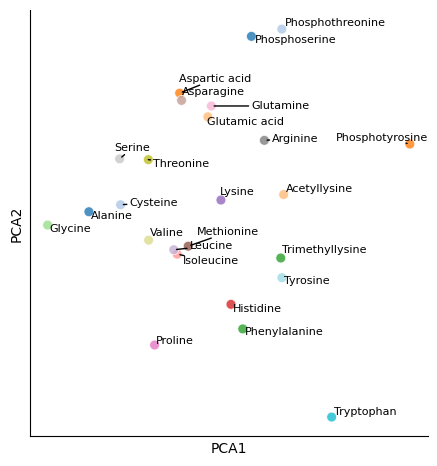

In [26]:
plot_cluster(aa_rdkit, name_list = aa.Name.tolist(), hue = 'aa')

## Bokeh interactive plot

In [27]:
#| export
def plot_bokeh(X:pd.DataFrame, # a dataframe of two columns from dimensionality reduction
               idx, # pd.Series or list that indicates identities for searching box
               hue:None, # pd.Series or list that indicates category for each sample
               s: int=3, # dot size
               **kwargs # key:args format for information to include in the dot information box
               ):
    
    "Make interactive 2D plot with a searching box and window of dot information when pointing "
        
    output_notebook()
    
    idx = list(idx)
    hue = list(hue)
    
    def assign_colors(categories, palette):
        "assign each unique name in a list with a color, returns a color list of same length"
        color_cycle = cycle(palette)
        color_map = {category: next(color_cycle) for category in categories}
        return [color_map[category] for category in categories]
    
    if hue is not None:
        colors  = assign_colors(hue, Category20_20) 
    else:
        colors = ['navy'] * len(X)
    
    data_dict={
    'x': X.iloc[:,0],
    'y': X.iloc[:,1],
    'identity': idx,
    'color': colors,
    'original_color': colors,
    'size': [s] * len(X), 
    'highlighted': ['no'] * len(X)  # To keep track of which dot is highlighted
    }
    
    for key, value in kwargs.items():
        data_dict[key] = value
    
    source = ColumnDataSource(data=data_dict)
    
    p = figure(tools="pan,box_zoom,wheel_zoom,reset")
    p.scatter('x', 'y', source=source, alpha=0.6, color='color', size='size')

    # Disable grid lines
    p.xgrid.visible = False
    p.ygrid.visible = False
    
    # Add hover tool
    hover = HoverTool()
    
    tooltips = [("Identity", "@identity")]

    for key in kwargs.keys():
        tooltips.append((key.capitalize(), f"@{key}"))

    
    hover.tooltips = tooltips
    p.add_tools(hover)
    
    
    autocomplete = AutocompleteInput(title="Search by Identity:", completions=idx)

    callback = CustomJS(args=dict(source=source, plot=p), code="""
        const data = source.data;
        const search_val = cb_obj.value.toLowerCase();
        const x = data['x'];
        const y = data['y'];
        const identity = data['identity'];
        const color = data['color'];
        const original_color = data['original_color'];
        const size = data['size'];
        const highlighted = data['highlighted'];

        for (let i = 0; i < identity.length; i++) {
            if (highlighted[i] === 'yes') {
                color[i] = original_color[i];
                size[i] = 10;
                highlighted[i] = 'no';
            }
            if (identity[i].toLowerCase() === search_val) {
                plot.x_range.start = x[i] - 5;
                plot.x_range.end = x[i] + 5;
                plot.y_range.start = y[i] - 5;
                plot.y_range.end = y[i] + 5;
                color[i] = 'red';
                size[i] = 15;
                highlighted[i] = 'yes';
            }
        }
        source.change.emit();
    """)
    autocomplete.js_on_change('value', callback)

    # Show layout
    layout = column(autocomplete, p)
    show(layout)

In [28]:
# PCA reduce dimension to 2
X = reduce_feature(aa_rdkit)

# get info
info=Data.get_aa_info()

#plot
plot_bokeh(X, 
           idx = info.Name,
           hue = info.Name,
           s=7, 
           smiles = info.SMILES)

Loading BokehJS ...

## Rank

In [29]:
#| export
@delegates(sns.scatterplot)
def plot_rank(sorted_df: pd.DataFrame, # a sorted dataframe
              x: str, # column name for x axis
              y: str, # column name for y aixs
              n_hi: int=10, # if not None, show the head n names
              n_lo: int=10, # if not None, show the tail n names
              figsize: tuple=(10,8), # figure size
              **kwargs # arguments for sns.scatterplot()
              ):
    
    "Plot rank from a sorted dataframe"

    plt.figure(figsize=figsize)
    
    sorted_df = sorted_df.reset_index(drop=True) # drop customized index
    
    sns_plot = sns.scatterplot(data=sorted_df, 
                               x = x,
                               y = y, **kwargs)

    sns_plot.set_xticks([])
    
    
    texts = []
    
    # Annotate the highest n values
    if n_hi is not None:
        
        for i, row in sorted_df.head(n_hi).iterrows():
            texts.append(plt.text(i, row[y], row[x], ha='center', va='bottom'))

    if n_lo is not None:
        # Annotate the lowest n values
        n_lowest = n_lo
        for i, row in sorted_df.tail(n_lowest).iterrows():
            texts.append(plt.text(i, row[y], row[x], ha='center', va='bottom'))
            
    if len(texts)>0:
        # Use adjustText to adjust text positions
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))
    plt.ylabel(y.capitalize())
    plt.tight_layout()

In [30]:
# load data
# df = Data.get_pspa_raw().set_index('kinase')
df = pd.read_csv('https://github.com/sky1ove/katlas_raw/raw/refs/heads/main/nbs/raw/pspa_st_raw.csv').set_index('kinase')


# get sorted dataframe
sorted_df = df.max(1).reset_index(name='values').sort_values('values')
sorted_df.head()

,kinase,values
68,CK1G2,189898.392
294,VRK2,4191709.640
8,ALPHAK3,4573611.730
249,PRPK,8495330.790
38,CAMLCK,9413689.600


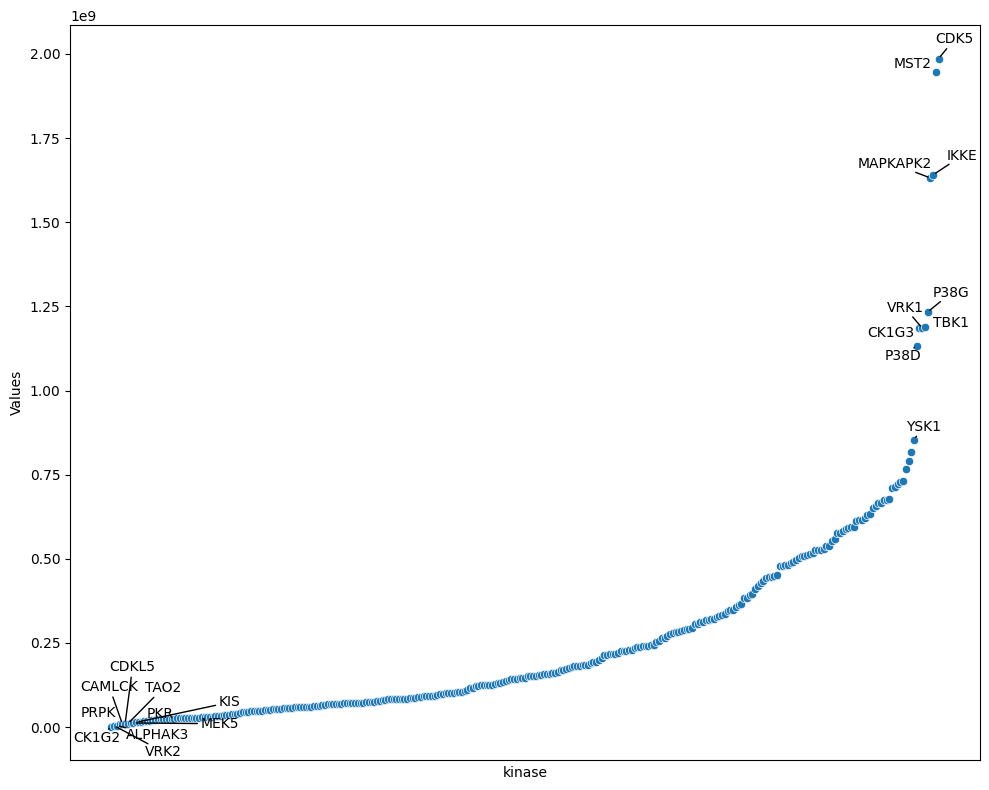

In [31]:
plot_rank(sorted_df,x='kinase',y='values')
plt.xlabel('kinase');

## Distribution histogram

In [32]:
#| export
@delegates(sns.histplot)
def plot_hist(df: pd.DataFrame, # a dataframe that contain values for plot
              x: str, # column name of values
              figsize: tuple=(6,2),
              **kwargs, # arguments for sns.histplot()
             ):
    
    hist_params = {'element':'poly',
              'edgecolor': None,
              'alpha':0.5,
              'bins':100,
              'kde':True}
    
    plt.figure(figsize=figsize)
    sns.histplot(data=df,x=x,**hist_params,**kwargs)

In [33]:
# we can use the same df
sorted_df.head()

,kinase,values
68,CK1G2,189898.392
294,VRK2,4191709.640
8,ALPHAK3,4573611.730
249,PRPK,8495330.790
38,CAMLCK,9413689.600


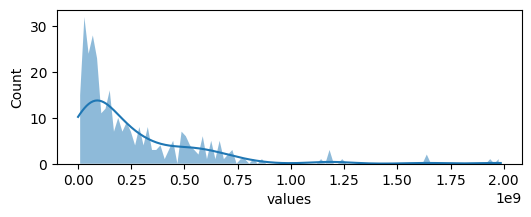

In [34]:
plot_hist(sorted_df,'values')

## Bar graph

In [35]:
#| export
def plot_count(cnt, # from df['x'].value_counts()
               tick_spacing: float= None, # tick spacing for x axis
               palette: str='tab20'):
    
    "Make bar plot from df['x'].value_counts()"

    cnt = cnt.sort_values(ascending=True).copy()
    
    c = sns.color_palette(palette)
    ax = cnt.plot.barh(color = c)
    ax.set_ylabel("")

    for index, value in enumerate(cnt):
        plt.text(value, index, str(value),fontsize=10,rotation=-90, va='center')
        # Set x-ticks at regular intervals
    if tick_spacing is not None:
        ax.xaxis.set_major_locator(MultipleLocator(tick_spacing))

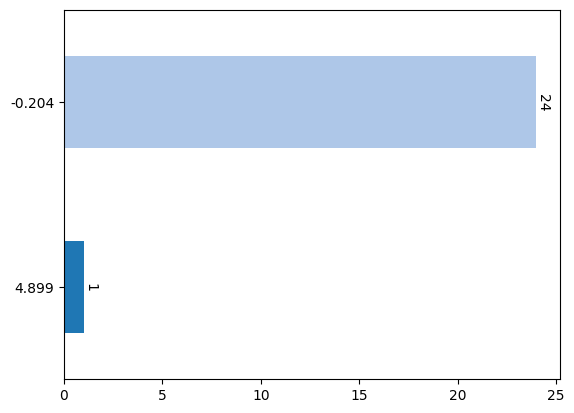

In [36]:
# get count
cnt = aa_rdkit.fr_sulfide.round(3).value_counts()

# make plot
plot_count(cnt)

In [37]:
#| export
@delegates(sns.barplot)
def plot_bar(df, 
             value, # colname of value
             group, # colname of group
             title = None,
             figsize = (12,5),
             fontsize=14,
             dots = True, # whether or not add dots in the graph
             rotation=90,
             ascending=False,
             **kwargs
              ):
    
    "Plot bar graph from unstacked dataframe; need to indicate columns of values and categories"
    
    plt.figure(figsize=figsize)
    
    idx = df.groupby(group)[value].mean().sort_values(ascending=ascending).index
    
    sns.barplot(data=df, x=group, y=value, order=idx,hue=group, legend=False, **kwargs)
    
    if dots:
        marker = {'marker': 'o', 
                  'color': 'white', 
                  'edgecolor': 'black', 
                  'linewidth': 1.5, 
                  'jitter':True,
                  's': 5}

        sns.stripplot(data=df, 
                      x=group, 
                      y=value,
                      order=idx,
                      alpha=0.8,
                      # ax=g.ax,
                      **marker)
        
    # Increase font size for the x-axis and y-axis tick labels
    plt.tick_params(axis='x', labelsize=fontsize)  # Increase x-axis label size
    plt.tick_params(axis='y', labelsize=fontsize)  # Increase y-axis label size
    
    # Modify x and y label and increase font size
    plt.xlabel('', fontsize=fontsize)
    plt.ylabel(value.capitalize(), fontsize=fontsize)
    
    # Rotate X labels
    plt.xticks(rotation=rotation)
    
    # Plot titles
    if title is not None:
        plt.title(title,fontsize=fontsize)
    
    plt.gca().spines[['right', 'top']].set_visible(False)

In [38]:
info['cat'] = (info.pKa1>2).astype(int)

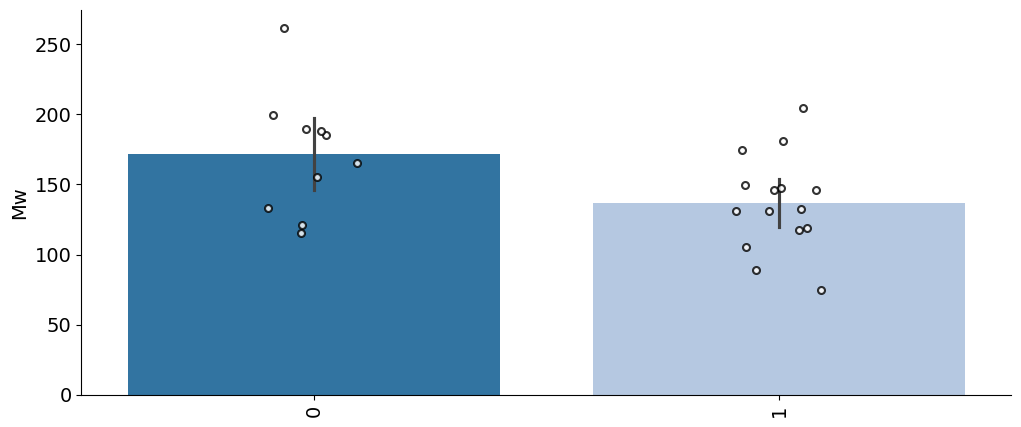

In [39]:
# get an unstacked dataframe
plot_bar(info,value='MW',group='cat',palette='tab20')

In [40]:
#| export
@delegates(sns.barplot)
def plot_group_bar(df, 
                   value_cols,  # list of column names for values, the order depends on the first item
                   group,       # column name of group (e.g., 'kinase')
                   figsize=(12, 5),
                   order=None,
                   title=None,
                   fontsize=14,
                   rotation=90,
                   **kwargs):
    
    " Plot grouped bar graph from dataframe. "

    # Prepare the dataframe for plotting
    # Melt the dataframe to go from wide to long format
    df_melted = df.melt(id_vars=group, value_vars=value_cols, var_name='Ranking', value_name='Value')

    plt.figure(figsize=figsize)
    
    # Create the bar plot
    sns.barplot(data=df_melted, 
                x=group, 
                y='Value', 
                hue='Ranking', 
                order=order, 
                capsize=0.1,
                err_kws={'linewidth': 1.5,'color': 'gray'}, 
                alpha=1.0,
                **kwargs)
    
    # Increase font size for the x-axis and y-axis tick labels
    plt.tick_params(axis='x', labelsize=fontsize)  # Increase x-axis label size
    plt.tick_params(axis='y', labelsize=fontsize)  # Increase y-axis label size
    
    # Modify x and y label and increase font size
    plt.xlabel('', fontsize=fontsize)
    plt.ylabel('Value', fontsize=fontsize)
    
    # Rotate X labels
    plt.xticks(rotation=rotation)
    
    # Plot titles
    if title is not None:
        plt.title(title, fontsize=fontsize)
    
    plt.gca().spines[['right', 'top']].set_visible(False)
    # plt.legend(fontsize=fontsize) # if change legend location, use loc='upper right'
    plt.legend(
        fontsize=fontsize,
        loc="upper left",
        bbox_to_anchor=(1.02, 1),
        borderaxespad=0
    )

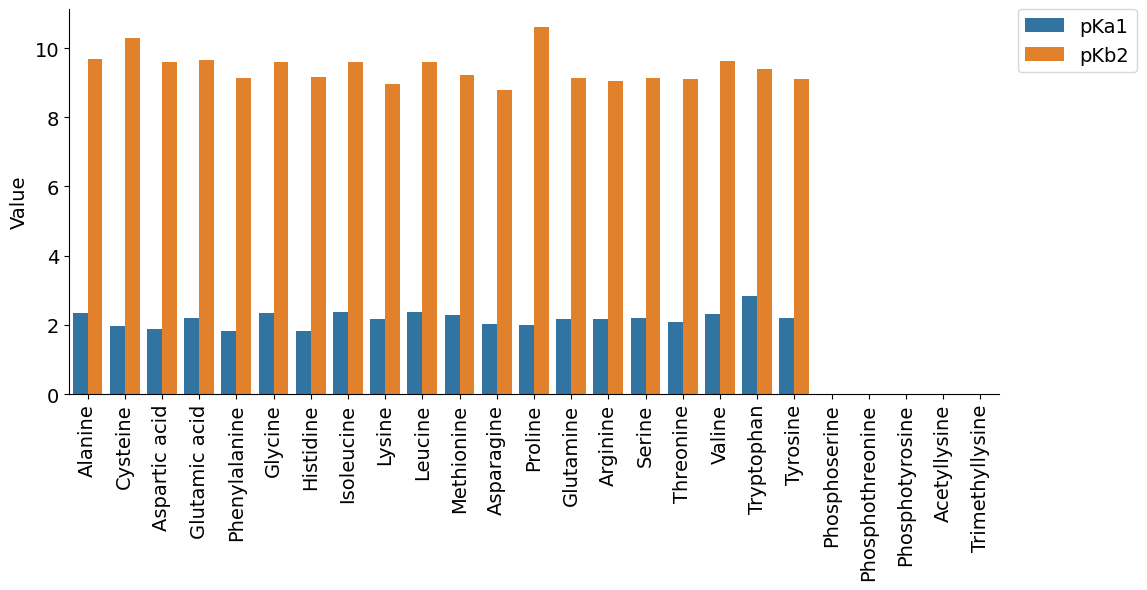

In [41]:
plot_group_bar(info,['pKa1','pKb2'],'Name')

## Stacked bar graph

In [42]:
#| export
def plot_stacked(df, column, hue, figsize=(5, 4),xlabel=None, ylabel=None, add_value=True, **kwargs):
    plt.figure(figsize=figsize)
    
    ax = sns.histplot(
        data=df,
        x=column,
        hue=hue,
        multiple='stack',
        discrete=True,
        shrink=0.8,
        alpha=1.0,
        **kwargs
    )

    plt.xlabel(xlabel.capitalize())
    plt.ylabel(ylabel.capitalize())
    plt.xticks(rotation=0)
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

    # Add total count on top of each bar
    if add_value:
        total_counts = df[column].value_counts().sort_index()
        for idx, (label, count) in enumerate(total_counts.items()):
            ax.text(idx, count + 1, str(count), ha='center', va='bottom', fontsize=9)

    plt.tight_layout()

## Box plot

In [43]:
#| export
@delegates(sns.boxplot)
def plot_box(df,
             value, # colname of value
             group, # colname of group
             title=None, 
             figsize=(6,3),
             fontsize=14,
             dots=True, 
             rotation=90,
             **kwargs
            ):
    
    "Plot box plot."
    
    plt.figure(figsize=figsize)
    
    idx = df[[group,value]].groupby(group).median().sort_values(value,ascending=False).index
    
    
    sns.boxplot(data=df, x=group, y=value, order=idx,hue=group, legend=False, **kwargs)
    
    if dots:
        sns.stripplot(x=group, y=value, data=df, order=idx, jitter=True, color='black', size=3)
        

    # Increase font size for the x-axis and y-axis tick labels
    plt.tick_params(axis='x', labelsize=fontsize)  # Increase x-axis label size
    plt.tick_params(axis='y', labelsize=fontsize)  # Increase y-axis label size

    plt.xlabel('', fontsize=fontsize)
    plt.ylabel(value.capitalize(), fontsize=fontsize)

    plt.xticks(rotation=rotation)
    
    if title is not None:
        plt.title(title,fontsize=fontsize)
    
    # Remove right and top spines 
    # plt.gca().spines[['right', 'top']].set_visible(False)
    

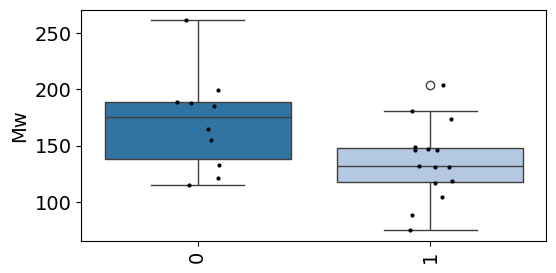

In [44]:
plot_box(info,value='MW',group='cat',palette='tab20')

## Pearson correlation

In [45]:
#| export
@delegates(sns.regplot)
def plot_corr(x, # x axis values, or colname of x axis
              y, # y axis values, or colname of y axis
              xlabel=None,# x axis label
              ylabel=None,# y axis label
              data = None, # dataframe that contains data
              text_location = [0.8,0.1],
              **kwargs
              ):
    "Given a dataframe and the name of two columns, plot the two columns' correlation"
    if data is not None:
        x=data[x]
        y=data[y]
        
    pear, pvalue = pearsonr(x, y)
        
    sns.regplot(
                x=x,
                y=y,
                line_kws={'color': 'gray'}, **kwargs
           )
    
    if xlabel is not None: plt.xlabel(xlabel.capitalize())
        
    if ylabel is not None: plt.ylabel(ylabel.capitalize())
    
    # correlation_text = f'Spearman: {correlation:.2f}' if method == 'spearman' else f'Pearson: {correlation:.2f}'

    # plt.text(x=0.8, y=0.1, s=correlation_text, transform=plt.gca().transAxes, ha='center', va='center')
    plt.text(s=f'Pearson = {round(pear,2)}\n   p = {"{:.2e}".format(pvalue)}',
             x=text_location[0],y=text_location[1],
            transform=plt.gca().transAxes, 
             ha='center', va='center')

In [46]:
norm = Data.get_pspa_st_norm().iloc[:,:-6].T

norm.head()

kinase,AAK1,ACVR2A,ACVR2B,AKT1,AKT2,AKT3,ALK2,ALK4,ALPHAK3,AMPKA1,...,VRK1,VRK2,WNK1,WNK3,WNK4,YANK2,YANK3,YSK1,YSK4,ZAK
-5P,0.0720,0.0415,0.0533,0.0603,0.0602,0.0705,0.0536,0.0552,0.0571,0.0555,...,0.0710,0.0684,0.0482,0.0413,0.0369,0.0580,0.0625,0.0590,0.0593,0.0604
-5G,0.0245,0.0481,0.0517,0.0594,0.0617,0.0624,0.0659,0.0574,0.0478,0.0504,...,0.0786,0.0676,0.0510,0.0572,0.0523,0.0699,0.0776,0.0713,0.0728,0.0641
-5A,0.0284,0.0584,0.0566,0.0552,0.0643,0.0745,0.0662,0.0605,0.0253,0.0534,...,0.0633,0.0636,0.0555,0.0503,0.0539,0.0637,0.0647,0.0731,0.0744,0.0659
-5C,0.0456,0.0489,0.0772,0.0605,0.0582,0.0628,0.0762,0.0483,0.0384,0.0588,...,0.0641,0.0644,0.0576,0.0732,0.0544,0.0602,0.0598,0.0606,0.0734,0.0631
-5S,0.0425,0.0578,0.0533,0.0516,0.0534,0.0442,0.0567,0.0574,0.0571,0.0504,...,0.0595,0.0573,0.0561,0.0569,0.0580,0.0580,0.0545,0.0542,0.0597,0.0597


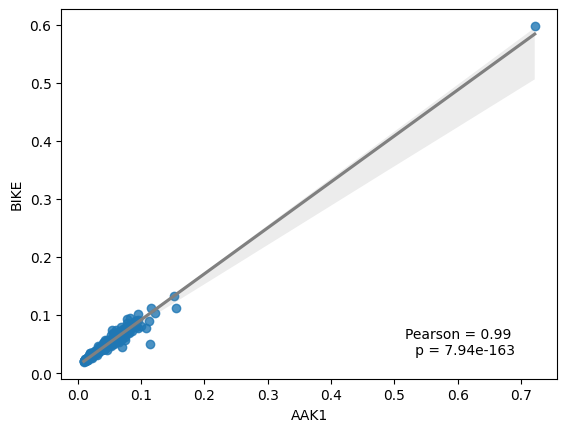

In [47]:
plot_corr(data=norm, x='AAK1', y='BIKE')

## Matrix heatmap

In [48]:
#| export
def get_similarity(df, metric='euclidean'):
    "Calculate distance matrix of a df; also return inverse df (similarity df)"
    dist_matrix = pairwise_distances(df, metric=metric)
    dist_df = pd.DataFrame(dist_matrix, index=df.index, columns=df.index)
    
    sigma = np.mean(dist_matrix)
    sim_df = np.exp(-dist_df**2 / (2 * sigma**2))
    return dist_df, sim_df

In [49]:
#| export
def plot_matrix(dist_matrix, inverse_color=False):
    "Plot distance/similarity matrix"
    
    mask = np.triu(np.ones_like(dist_matrix, dtype=bool))
    cmap = 'coolwarm' if not inverse_color else 'coolwarm_r'
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        dist_matrix,
        cmap=cmap,
        mask=mask,
        # annot=False,
        # fmt='.2f',
        linewidths=0.1,  
        linecolor='white' 
    )
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks(rotation=0)

In [50]:
rdkit_corr = aa_rdkit.T.corr()
rdkit_corr.head()

aa,A,C,D,E,F,G,H,I,K,L,...,S,T,V,W,Y,s,t,y,Kac,Kme3
aa,,,,,,,,,,,,,,,,,,,,,
A,1.000000,0.362249,0.090196,-0.112113,-0.188293,0.725521,-0.000237,0.187125,-0.097937,0.268178,...,0.560591,0.377388,0.295328,-0.344602,-0.292387,-0.258079,-0.295116,-0.539359,-0.446868,-0.354002
C,0.362249,1.000000,-0.064584,-0.172896,-0.248329,0.409360,0.008505,0.006581,-0.244799,-0.029344,...,0.298892,0.143643,0.101313,-0.220372,-0.274306,-0.039629,-0.154905,-0.339130,-0.298043,-0.210555
D,0.090196,-0.064584,1.000000,0.803705,-0.304791,0.065515,-0.212494,-0.275195,-0.228883,-0.265916,...,0.302819,0.228122,-0.181298,-0.339660,-0.192213,0.386291,0.294720,-0.044411,-0.132255,-0.232235
E,-0.112113,-0.172896,0.803705,1.000000,-0.240949,-0.068617,-0.240172,-0.212345,-0.104513,-0.268210,...,0.043379,-0.043011,-0.170243,-0.250481,-0.049087,0.241681,0.166118,0.098374,0.124964,-0.177524
F,-0.188293,-0.248329,-0.304791,-0.240949,1.000000,-0.154844,0.011327,0.092312,0.021107,0.108388,...,-0.350124,-0.327162,-0.000429,0.660842,0.453215,-0.358662,-0.300383,0.254419,-0.089556,0.023795


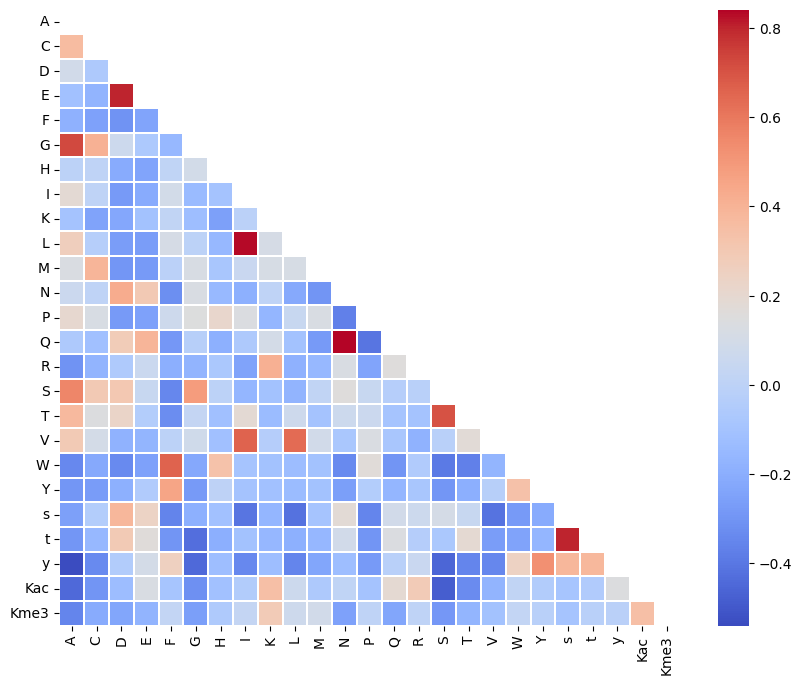

In [51]:
plot_matrix(rdkit_corr)

## AUCDF

We compute the area under the empirical cumulative distribution function (CDF) as a function of kinase rank using the trapezoidal rule.  
Let $ r_{(1)} < r_{(2)} < \dots < r_{(n)} $ be the sorted rank values (e.g., $1,2,\dots,n$), and define the empirical CDF values as:

$$
F(r_{(i)}) = \frac{i}{n}
$$

The normalized area under this CDF-vs-rank curve (AUCDF) is then computed via the trapezoidal rule:

$$
\text{AUC}_{\text{CDF}} =
\frac{1}{r_{\max} - r_{\min}} \sum_{i=1}^{n-1}
\frac{F(r_{(i)}) + F(r_{(i+1)})}{2} \cdot (r_{(i+1)} - r_{(i)})
$$

where $ r_{\min} = r_{(1)} $, typically 1; $ r_{\max} = r_{(n)} $, typically $n$.

This measures how quickly the cumulative mass increases across the ranked kinases. If better kinases (lower rank) tend to appear earlier in the CDF, the AUCDF will be higher.

In [52]:
#| export
def get_AUCDF(df,col, reverse=False,plot=True,xlabel='Rank of reported kinase'):
    
    "Plot CDF curve and get relative area under the curve"
    
    # sort col values as x values
    x_values = df[col].sort_values().values
    
    # get y_values evenly distributed from 0 to 1
    # y_values = np.arange(1, len(x_values) + 1) / len(x_values) # this method assumes equal distribution of each x value
    y_values = pd.Series(x_values).rank(method='average', pct=True).values # this method takes duplicates into account
    
    if reverse:
        y_values = 1 - y_values + y_values.min()  # Adjust for reverse while keeping the distribution's integrity
    # calculate the area under the curve using the trapezoidal rule
    area_under_curve = np.trapezoid(y_values, x_values)
    
    # calculate total area
    # total_area = (x_values[-1] - x_values[0]) * (y_values[-1] - y_values[0])
    total_area = (x_values[-1] - x_values[0]) * 1
    

    AUCDF = area_under_curve / total_area
    if reverse:
        AUCDF = -AUCDF
    
    if plot:
        # Create a figure and a primary axis
        fig, ax1 = plt.subplots(figsize=(7,5))
        
        # fontsize
        fontsize=17
        
        # Plot the histogram on the primary axis
        sns.histplot(x_values,bins=20,ax=ax1)
        ax1.set_xlabel(xlabel,fontsize=fontsize)
        ax1.set_ylabel('Substrates',color='darkblue',fontsize=fontsize)
        ax1.tick_params(axis='y', labelcolor='darkblue',labelsize=fontsize)
        ax1.tick_params(axis='x', labelcolor='black',labelsize=fontsize)
        ax1.set_xlim(min(x_values),max(x_values))

        # Create a secondary axis for the CDF
        ax2 = ax1.twinx()

        # Plot the CDF on the secondary axis
        # ax2.plot(bin_edges[:-1], cumulative_data, color='red', linestyle='-', linewidth=2.0)
        ax2.plot(x_values, y_values, color='darkred', linestyle='-', linewidth=2.0)
        if reverse:
            ax2.plot([max(x_values),0],[0, max(y_values)], 'k--')  # 'k--' is for a black dashed line
        else:
            ax2.plot([0, max(x_values)], [0, max(y_values)], 'k--')  # 'k--' is for a black dashed line

        ax2.set_ylabel('Probability', color='darkred',fontsize=fontsize,rotation=270,labelpad=18)
        if reverse:
            ax2.text(0.45, 0.3, f"AUCDF:{AUCDF.round(4)}", transform=plt.gca().transAxes, ha='right', va='bottom',fontsize=fontsize)
        else:
            ax2.text(0.95, 0.3, f"AUCDF:{AUCDF.round(4)}", transform=plt.gca().transAxes, ha='right', va='bottom',fontsize=fontsize)
        ax2.tick_params(axis='y', labelcolor='darkred',labelsize=fontsize)
        ax2.set_ylim(0, 1)  # Probabilities range from 0 to 1

        # Show the plot
        plt.title(f'{len(x_values):,} kinase-substrate pairs',fontsize=fontsize)
        plt.show()
        
    return AUCDF

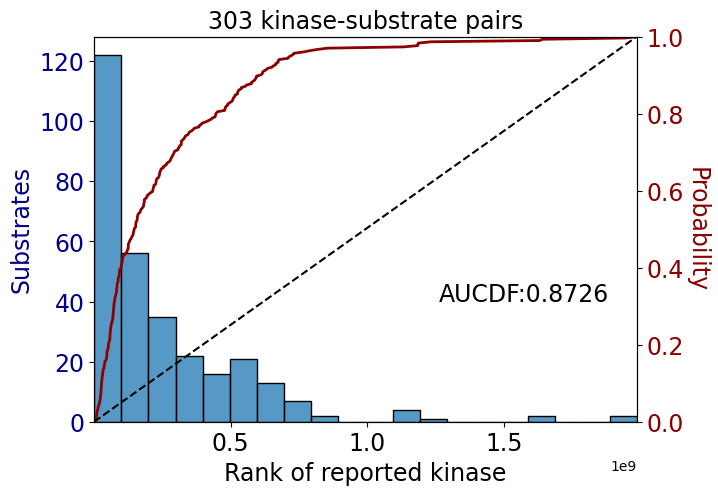

np.float64(0.872608302329996)

In [53]:
get_AUCDF(sorted_df,'values')

## Confusion matrix

In [54]:
#| export
def plot_confusion_matrix(target, # pd.Series 
                          pred, # pd.Series
                          class_names:list=['0','1'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    "Plot the confusion matrix."
    
    cm = confusion_matrix(target, pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, cmap=cmap)  # Plot the heatmap
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(np.arange(len(class_names)) + 0.5, class_names)
    plt.yticks(np.arange(len(class_names)) + 0.5, class_names, rotation=0)

In [55]:
target = info.MW<160
pred = info.pKa1>2.1

Normalized confusion matrix


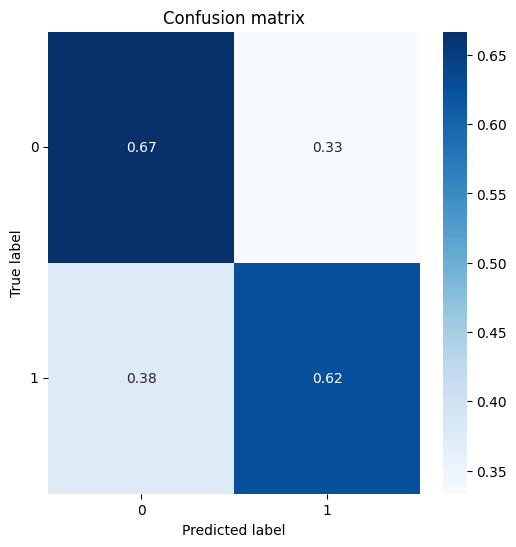

In [56]:
plot_confusion_matrix(target,pred,normalize=True)

## Pie plot

In [57]:
#| export
def plot_pie(value_counts, # value counts
             hue_order=None, # list of strings
             labeldistance=0.8,
             fontsize=12,
             fontcolor='black',
             palette='tab20' ,
             figsize=(4,3)
            ):
    if hue_order is not None: value_counts = value_counts.reindex(hue_order)
    colors = sns.color_palette(palette, n_colors=len(value_counts))
    value_counts.plot.pie(
        autopct='%1.1f%%',    # Show percentage inside slices
        labeldistance=labeldistance,    # Move labels closer to center
        textprops={'fontsize': fontsize, 'color': fontcolor} ,
        colors=colors,
        figsize=figsize,
    )
    plt.ylabel('')
    plt.title(f'n={value_counts.sum():,}')

In [58]:
info=Data.get_kinase_info()

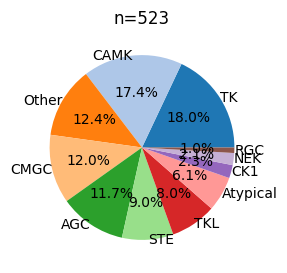

In [59]:
plot_pie(info.modi_group.value_counts(),
         fontsize=10,
         labeldistance=1)

## Bar composition

In [60]:
#| export
def get_pct(df,bin_col, hue_col):
    "Get percentage for hue in each bin; with hue adding up to 1 in each bin."
    count_df = df.groupby([bin_col, hue_col], observed=False).size().unstack(fill_value=0)
    pct_df = count_df.div(count_df.sum(axis=1), axis=0) * 100
    return pct_df

In [61]:
#| export
def plot_composition(df, bin_col, hue_col,palette='tab20',legend_title=None,rotate=45,xlabel=None,ylabel='Percentage',figsize=(5,3)):
    pct_df = get_pct(df,bin_col,hue_col)

    colors = get_plt_color(palette,pct_df.columns)
    
    pct_df.plot(kind='bar', figsize=figsize,stacked=True,color=colors)
    
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.xticks(rotation=rotate)
    if legend_title is None: legend_title = hue_col 
    plt.legend(title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')

## Plot bar count with value text

In [62]:
#| export
def plot_cnt(cnt, xlabel=None,ylabel='Count',figsize=(6, 3)):
    fig, ax = plt.subplots(figsize=figsize)
    cnt.plot.bar(ax=ax)
    # Add text on top of each bar
    for idx, value in enumerate(cnt):
        ax.text(idx, value + 0.5, f"{value:,}", ha='center', va='bottom', fontsize=10)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    plt.xticks(rotation=0)
    plt.tight_layout()

In [63]:
# plot_composition(sites,
#                  'bin',
#                  'source_combine',
#                  palette='Set2',
#                  legend_title='Source',
#                  figsize=(4,3)
#                 )

## End

In [64]:
#| hide
import nbdev; nbdev.nbdev_export()

In [65]:
# #| export
# def get_logo2(full: pd.DataFrame, # a dataframe that contains the full matrix of a kinase, with index as amino acid, and columns as positions
#               title: str = 'logo', # title of the graph
#               ):
    
#     "Plot logo from a full freqency matrix of a kinase"
    
#     # get S,T,Y ratio
#     S_ratio,T_ratio,Y_ratio = full[0][['s','t','y']]/full[0][['s','t','y']].sum()
    
#     # drop position 0 
#     full = full.drop(columns=[0])
    
#     # identify the minimum value other than 0
#     min_val = full[full > 0].min().min()
    
#     # replace 0s with the identified minimum value
#     full = full.replace(0, min_val)
    
#     norm_p = full.T

#     # calculate ratio, use substraction
#     ratio =norm_p.apply(lambda r: r-r.median(),axis=1)
    
#     # calculate ratio based on previous method, divide values by median, followed by log2
#     # ratio =norm_p.apply(lambda r: r/r.median(),axis=1)
#     # ratio = np.log2(ratio)
    
#     # get the max value for a position
#     m = ratio.apply(lambda row: row[row > 0].sum(), axis=1).max()
    
#     # get the relative height of S,T,Y relative to the max value
#     new_row = pd.DataFrame({'S': S_ratio*m, 'T':T_ratio*m,'Y':Y_ratio*m}, index=[0]) 
    
#     # prepare the matrix for logomaker
#     ratio2 = pd.concat([ratio, new_row], ignore_index=False).fillna(0)

#     # logo_func(ratio2,title)
#     plot_logo_raw(ratio2.T,title=title)

# # get kinase-substrate dataset
# df = Data.get_ks_dataset()

# # get data for a specific kinase
# df_k = df.query('kinase == "DYRK2"')

# # get the full freq matrix
# _,full = get_freq(ks_k)

# # plot logo
# get_logo2(full,'DYRK2')